In [ ]:
#| default_exp core

In [ ]:
%load_ext autoreload
%autoreload 2

# core_functions

> Functions to create a new set of *C* vectors directed outwards from a cloud of *A* and *B* points and visualize the result.

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
from fastcore.utils import *

In [ ]:
#| export
from __future__ import annotations

import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from scipy.spatial import ConvexHull

#### 1. Load input data

In [ ]:
#| export
def load_input_data(
        path: str,      # path to data file
    ) -> pd.DataFrame:  
    "Load data from a txt file with headers [label, x, y, z] and values separated by spaces."
    
    df = pd.read_csv(path, delimiter=" ", names=["label", "x", "y", "z"])
    return df

In [ ]:
input_data = load_input_data("../data/cdd.txt")

In [ ]:
input_data.head().round(2)

,label,x,y,z
0,A,2.36,-0.45,0.65
1,A,0.97,-0.12,0.40
2,B,0.70,1.29,0.19
3,A,0.04,1.50,-1.14
4,A,0.01,0.14,-1.81


In [ ]:
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   24 non-null     object 
 1   x       24 non-null     float64
 2   y       24 non-null     float64
 3   z       24 non-null     float64
dtypes: float64(3), object(1)
memory usage: 896.0+ bytes


The input contains a list of 24 points, each of which is defined by a `label` and its *xyz*-coordinates.

In [ ]:
input_data["label"].value_counts()

label
B    15
A     9
Name: count, dtype: int64

There are 2 different subsets of points: 9 *A* points and 15 *B* points.

#### 2. Calculate the centroid of the point cloud 

In [ ]:
#| export
def get_centroid(
        points: np.array, # xyz-coords of points
    ) -> np.array:        
    "Calculate centroid of point cloud."

    nps = points.shape[0]
    centroid = np.array([points[:,i].mean() for i in range(points.shape[1])])
    return centroid

In [ ]:
centroid = get_centroid(input_data[["x", "y", "z"]].values)
centroid.round(2)

array([ 0.24, -0.16, -0.31])

#### 3. Generate new *C* points from *B* points 

First create a function to select the *B* points:

In [ ]:
#| export
def get_labeled_points(
        input_data: pd.DataFrame,  # points labels and xyz-coords
        label: str                 # label of subset of points
    ) -> np.array:              
    "Select subset of points by label."
    
    subset = input_data[input_data["label"]==label]
    return subset[["x", "y", "z"]].values

In [ ]:
B_points = get_labeled_points(input_data, "B")

In [ ]:
B_points.shape

(15, 3)

In [ ]:
B_points[:3].round(2)

array([[ 0.7 ,  1.29,  0.19],
       [ 0.23, -0.84, -0.63],
       [-1.49, -1.08,  0.14]])

Then, define a function that calculate a new point *C* at a given distance from a point *B* along the direction centroid->*B* 

In [ ]:
#| export
def calculate_C_point(
        B_point: np.array,     # B point
        centroid: np.array,    # centroid of point cloud
        distance: float=1.0    # prescribed distance D of the B->C vector
    ) -> np.array:
    "Given a point B, calculate a vector C originating from B and directed outwards from the point cloud, along the direction `centroid`-->`B_point`." 
    
    outwards_direction = (B_point - centroid) / np.linalg.norm(B_point - centroid)
    C_point = B_point + outwards_direction * distance
    return C_point

For each *B* point calculate the corresponding *C* point

In [ ]:
C_points = np.apply_along_axis(lambda p: calculate_C_point(p, centroid), 1, B_points)

In [ ]:
C_points[:3].round(2)

array([[ 0.99,  2.2 ,  0.5 ],
       [ 0.21, -1.74, -1.06],
       [-2.35, -1.54,  0.36]])

#### 4. Visualize the result

It is useful to visualize the results in 3D, together with the point cloud. First let's calculate the convex hull of the original point cloud and plot it

In [ ]:
#| export
def plot_convex_hull(
        ax: Axes3D,
        points: np.array,       # xyz-coords of points
    ) -> Axes3D:
    "3D plot of convex hull."
    
    convex_hull = ConvexHull(points)
    for s in convex_hull.simplices:
        s = np.append(s, s[0])
        ax.plot(points[s, 0], points[s, 1], points[s, 2], "-", color="gray")
    return ax

Now let's define the functions to plot the point cloud and the new vectors *C*

In [ ]:
#| export
def plot_points(
        ax: Axes3D,
        input_data: pd.DataFrame,     # labels and xyz-coords of points
    ) -> Axes3D:
    "3D plot of original points."
    
    for k in input_data["label"].unique():
        kps = get_labeled_points(input_data, k)
        ax.scatter(kps[:, 0], kps[:, 1], kps[:, 2], color=np.random.rand(3,), label=k)
    return ax

In [ ]:
#| export
def plot_vectors(
        ax, 
        vectors: np.array,    # vector to plot
        origins: np.array,    # origin of vector
        length: float=0.3,    # vector length
    ):
    "Plot vectors as arrows."
    
    for origin, vector in zip(origins, vectors):
        x, y, z = origin
        dx, dy, dz = vector * length
        ax.quiver(x, y, z, dx, dy, dz, arrow_length_ratio=0.5)

    return ax

In [ ]:
#| export
def plot_ABC(
        input_data: pd.DataFrame,     # labels and xyz-coords of points 
        C_points: np.array,           # calculated C points
        centroid: np.array            # centroid of point cloud    
    ) -> plt.figure:
    "Plot point cloud including its convex hull and the C vectors as arrows."
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    plot_points(ax, input_data)
    ax.scatter(centroid[0], centroid[1], centroid[2], marker="x", color="k", label="centroid")
    
    B_points = get_labeled_points(input_data, "B")
    plot_vectors(ax, C_points, B_points)
    plot_convex_hull(ax, input_data[["x", "y", "z"]].values)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    plt.legend()
    
    return fig

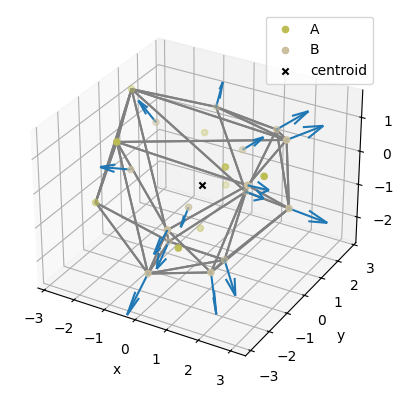

In [ ]:
fig = plot_ABC(input_data, C_points, centroid)

Let's create a function to run it all, end-to-end:

In [ ]:
#| export
def calculate_C_points(
        input_file: str,            # input file path with point A and B data
        output_file: str,           # output file path for the generated C points
        output_plot_file: str=None, # output file path for the plot of point cloud and C vectors
        distance: float=1.0,        # prescribed distance D of the B->C vectors
    ):
    "Calculate C points and export them to a file (together with the result plot, optionally)."

    print(f"Loading input data from '{input_file}'...")
    input_data = load_input_data(input_file)

    print("Calculate points...")
    centroid = get_centroid(input_data[["x", "y", "z"]].values)
    B_points = get_labeled_points(input_data, "B")
    C_points = np.apply_along_axis(lambda b_point: calculate_C_point(b_point, centroid, distance), 1, B_points)

    print(f"Saving result data to '{output_file}'...")
    np.savetxt(output_file, C_points)

    if output_plot_file:
        print(f"Exporting plots to '{output_plot_file}'...")
        fig = plot_ABC(input_data, C_points, centroid)
        fig.savefig(output_plot_file)

    print("Done.")

And run it on the input data:

In [ ]:
input_data = "../data/cdd.txt"
output_result = "../data/result_C_points.txt"
output_plot = "../data/result_plot.png"

Loading input data from '../data/cdd.txt'...
Calculate points...
Saving result data to '../data/result_C_points.txt'...
Exporting plots to '../data/result_plot.png'...
Done.


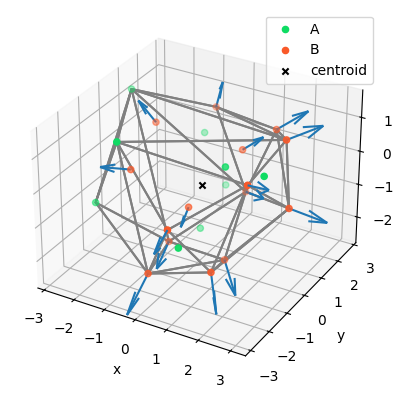

In [ ]:
calculate_C_points(input_data, output_result, output_plot_file=output_plot)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()